# See Through Gradients: Image Batch Recovery via GradInversion

This notebook shows an example for a **small batch image gradient inversion** as described in "See Through Gradients: Image Batch Recovery via GradInversion".

Paper URL: https://openaccess.thecvf.com/content/CVPR2021/html/Yin_See_Through_Gradients_Image_Batch_Recovery_via_GradInversion_CVPR_2021_paper.html

This is only a partial re-implementation of the original attack for which no code is available.

#### Abstract
Training deep neural networks requires gradient estimation from data batches to update parameters. Gradients per parameter are averaged over a set of data and this has been presumed to be safe for privacy-preserving training in joint, collaborative, and federated learning applications. Prior work only showed the possibility of recovering input data given gradients under very restrictive conditions - a single input point, or a network with no non-linearities, or a small 32x32 px input batch. Therefore, averaging gradients over larger batches was thought to be safe. In this work, we introduce GradInversion, using which input images from a larger batch (8 - 48 images) can also be recovered for large networks such as ResNets (50 layers), on complex datasets such as ImageNet (1000 classes, 224x224 px). We formulate an optimization task that converts random noise into natural images, matching gradients while regularizing image fidelity. We also propose an algorithm for target class label recovery given gradients. We further propose a group consistency regularization framework, where multiple agents starting from different random seeds work together to find an enhanced reconstruction of original data batch. We show that gradients encode a surprisingly large amount of information, such that all the individual images can be recovered with high fidelity via GradInversion, even for complex datasets, deep networks, and large batch sizes.

### Startup

In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [2]:
cfg = breaching.get_config(overrides=["case=5_small_batch_imagenet", "attack=seethroughgradients"])
          
device = torch.device(f'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case small_batch_imagenet with server type honest_but_curious.


{'device': device(type='cuda', index=0), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [3]:
cfg.case.data.partition="unique-class"
cfg.case.user.user_idx = 24

cfg.case.user.num_data_points = 1

cfg.case.model = "resnet50" # also options are resnet50ssl or just a normal resnet50

# In this paper, there are no public buffers, but users send their batch norm statistic updates in combination 
# with their gradient updates to the server:
cfg.case.server.provide_public_buffers = False
cfg.case.user.provide_buffers = True

In [4]:
# cfg.attack.optim.langevin_noise = 1e-4
# cfg.attack.objective.scale = 1e-3

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [5]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture resnet50 loaded with 24,321,485 parameters and 53,173 buffers.
Overall this is a data ratio of     162:1 for target shape [1, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: False
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 24
    
        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet50
        model state: default
        public buffers: False

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: see-through-gradients

    Objective: Euclidean loss with scale=0.0001 and task reg=0.0
    Regularizers: Total Variation, scale=0.0001. p=1 q=1. 
                  Input L^p 

### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [6]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update on user 24 in model mode: training.


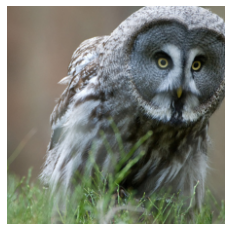

In [7]:
user.plot(true_user_data)

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

You can interrupt the computation early to see a partial solution.

In [ ]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

Recovered labels [24] through strategy yin.
| It: 1 | Rec. loss: 46.6031 |  Task loss: 14.2809 | T: 0.46s
| It: 1001 | Rec. loss: 8.8915 |  Task loss: 0.0293 | T: 128.63s
| It: 2001 | Rec. loss: 41.7048 |  Task loss: 7.3327 | T: 98.55s
| It: 3001 | Rec. loss: 7.8202 |  Task loss: 0.0357 | T: 98.54s
| It: 4001 | Rec. loss: 13.1918 |  Task loss: 0.0336 | T: 98.62s
| It: 5001 | Rec. loss: 10.8099 |  Task loss: 0.0299 | T: 97.58s
| It: 6001 | Rec. loss: 3.8350 |  Task loss: 0.0223 | T: 96.85s
| It: 7001 | Rec. loss: 7.1364 |  Task loss: 0.0109 | T: 96.89s
| It: 8001 | Rec. loss: 10.0678 |  Task loss: 0.0330 | T: 96.58s
| It: 9001 | Rec. loss: 1.4867 |  Task loss: 0.0378 | T: 96.68s
| It: 10001 | Rec. loss: 11.2283 |  Task loss: 0.0285 | T: 97.86s
| It: 11001 | Rec. loss: 2.2508 |  Task loss: 0.0245 | T: 97.24s
| It: 12001 | Rec. loss: 9.6998 |  Task loss: 0.0280 | T: 97.12s
| It: 13001 | Rec. loss: 1.9263 |  Task loss: 0.0240 | T: 97.46s
| It: 14001 | Rec. loss: 1.9546 |  Task loss: 0.0077

Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [ ]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

And finally, we also plot the reconstructed data:

In [ ]:
user.plot(reconstructed_user_data)

### Notes:
* Reconstructions with the Deep Inversion regularization take a while to compute.
* Likely settings for the Deep Inversion regularization are reverse-engineered from the related NVIDIA repository https://github.com/NVlabs/DeepInversion
* This is only a partial implementation of See Through Gradients: The Group Registration part is not included (and not entirely clear to me (Jonas Geiping) from the paper only)
* In some configurations of this attacks, the gradient reconstruction objective can actually be completely disabled and images can be recovered just as well based only on their batch norm statistics!